# 7. 텍스트 문서의 범주화 - (1) 텍스트 임베딩


### 텍스트 분류의 예시
- 스팸 메일 필터링
- 감성 분류
- 장르 분류
- 보험금 청구서 사기 탐지 등

### 전통적인 텍스트 범주화
- 문장 나누기
- 토큰화(Tokenization)
- 어간 추출 (Stemming)
    - ('재생해', '재생하고', '재생했다') -> 기본형 '재생하다'
- 원형 복원 (Lemmatization)
    - 'better' -> 원형 'good' (사전에 정의됨)
- 텍스트 정리 : 대소문자 변환, 오타 수정, 불용어 제거 등

### BoW (Bag of Words)
- 텍스트 문서에서 특징을 추출하고 텍스트의 벡터 표현을 생성하는, 가장 간단하면서도 강력한 기술 중 하나
- 순서 없이 각 단어의 빈도를 기반으로 생성한 희소한(sparse) 벡터

### TF-IDF (Term Frequency – Inverse Document Frequency)
- TF-IDF 값은 어떤 단어가 특정 문서에 나타나는 횟수에 비례하여 늘어나고, 그 단어가 전체 문서에서 두루 나타나는 빈도수에 비례하여 작아진다
- TF-IDF = TF x IDF
    - TF : 문서 내 단어가 등장한 빈도
    - IDF : 단어가 다른 문서에 자주 등장한 빈도의 역수

### Word2Vec
- 예측을 통한 심층 학습 기반 모델로서  밀집, 고품질, 분산성, 연속성을 가진 단어 표현 벡터를 생성한다. 
- 단어 표현 벡터는 문맥과 의미의 유사성을 표현한다
- 단어 임베딩 표현을 만들기 위해 두 가지 아키텍처
    - CBOW (Continuous Bag of Words)
    - Skip-gram

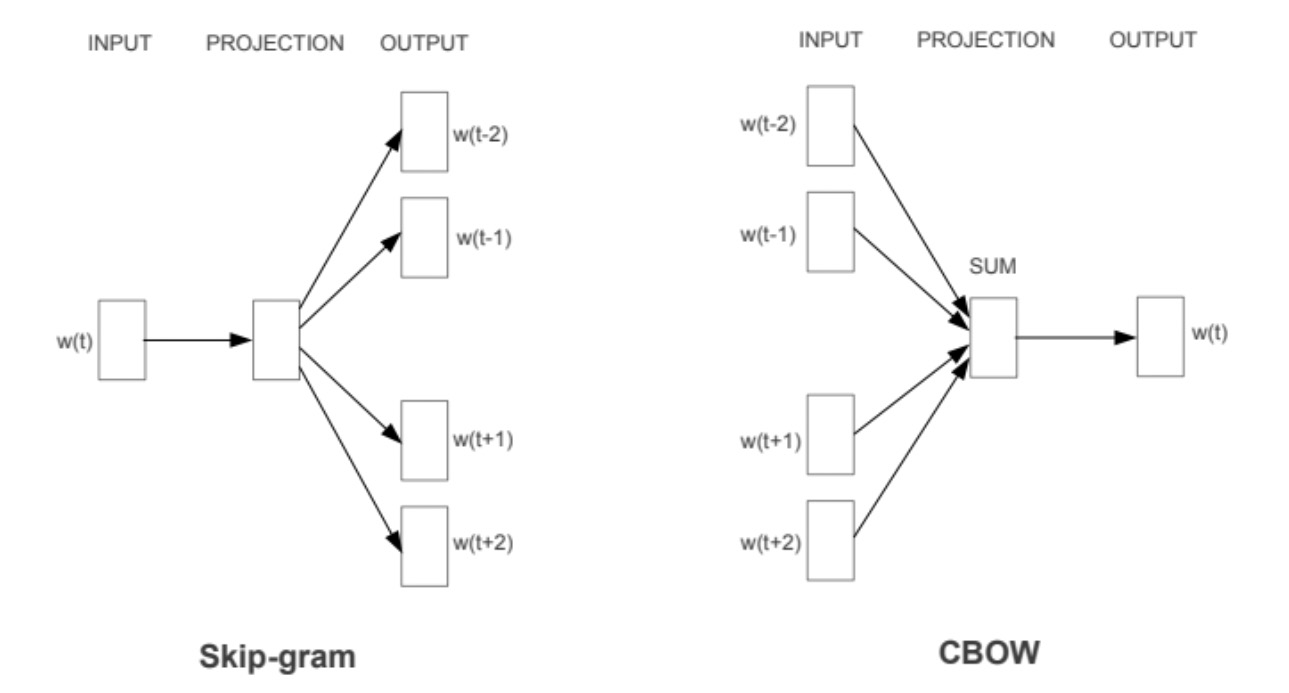

In [1]:
import os
import nltk
import logging
import pandas as pd
import numpy as np
from gensim.models import word2vec
from dataloader.loader import Loader

----
## 1. load IMDB data

- data/aclImdb 경로에 저장한 IMDB 영화 리뷰 데이터 (10만건, 510MB)를 로드한다
- IMDB 영화 리뷰 데이터 세트: 
    - 바이너리로 감성을 분류하기 위한 데이터 세트다. 훈련을 위한 25,000개 영화 리뷰 데이터와 테스트를 위한 25,000개 영화 리뷰 데이터가 포함돼 있다. 또한 레이블이 지정되지 않은 추가 데이터도 있다. 이 데이터 세트는 http://ai.stanford.edu/~amaas/data/sentiment/ 에서 내려받을 수 있다.
- 로드 함수는 dataloader/loader.py 참조

In [2]:
# train, test, unsup 데이터 로드하기

train_df = Loader.load_imdb_data('train')
print(f'train_df.shape : {train_df.shape}')

test_df = Loader.load_imdb_data('test')
print(f'test_df.shape : {test_df.shape}')

unsupervised = Loader.load_imdb_unsup()
print(f'unsupervised.shape : {unsupervised.shape}')

train_df.shape : (25000, 2)
test_df.shape : (25000, 2)
unsupervised.shape : (50000, 1)


In [3]:
train_df.head()

,review,sentiment
10245,This is a documentary that came out of the spl...,1
9403,One of the more sensible comedies to hit the H...,1
4501,Incredibly ARTISTIC NOBODY COULD MAKE THEM NOW...,1
18648,"I've gotta say, I usually like horror movies t...",0
16011,"I have seen many, many films from China - and ...",0


In [4]:
# 로드한 train, test, unsupervised 텍스트 데이터를 하나로 묶기
corpus = unsupervised['review'].tolist() + train_df['review'].tolist() + test_df['review'].tolist()
print(f'corpus size : {len(corpus)}')

corpus size : 100000


----
## 2. tokenize

- 각 문장을 단어들의 리스트로 tokenize한다

In [5]:
# tokenize sentences in corpus
# nltk.word_tokenize와 달리, 단어 속 특수기호도 모두 split한다
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document.lower()) for document in corpus]
print(f'tokenized_corpus size : {len(tokenized_corpus)}')
print(f'tokenized_corpus[0] : \n', tokenized_corpus[0])

tokenized_corpus size : 100000
tokenized_corpus[0] : 
 ['when', 'you', 'start', 'to', 'watch', 'this', 'film', ',', 'it', 'never', 'gets', 'boring', '.', 'for', 'those', 'who', 'have', 'seen', 'the', 'original', ',', 'you', 'can', 'see', 'that', 'romero', 'stayed', 'very', 'close', 'to', 'the', 'original', 'movie', 'with', 'alterations', 'of', 'course', 'which', 'looked', 'like', 'politically', 'correct', 'moves', 'if', 'you', 'ask', 'me', '.', 'i', 'will', 'get', 'to', 'that', 'later', '.', 'from', 'beginning', 'to', 'end', 'we', 'see', 'what', 'effect', 'it', 'has', 'on', 'a', 'small', 'group', 'of', 'people', 'locked', 'inside', 'a', 'house', '.', 'here', 'the', 'characters', 'are', 'very', 'much', 'like', 'in', 'the', 'original', 'with', 'the', 'exception', 'of', 'barbara', '.', 'her', 'character', 'has', 'changed', 'while', 'the', 'girlfriend', 'of', 'tom', 'behaves', 'very', 'much', 'like', 'barbara', 'of', 'the', 'original', ',', 'even', 'though', 'in', 'the', 'original', 'the',

----
## 3. train word2vec
- 본 구간은 도서의 소스코드대로(iter=1000) 실행시키면 5~6시간 이상 소요되므로 주의바랍니다.
- 간단하게 실습해보려면 Word2Vec의 iter 파라미터 값을 2~5 정도로 작게 주세요

In [6]:
# word2vec 학습 과정 로그찍기
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# word2vec 모델 학습
w2v_model = word2vec.Word2Vec(tokenized_corpus, 
                              size=50,      # Word vector dimensionality
                              window=10,    # Context window size
                              min_count=5,  # Minimum word count
                              sample=1e-3,  # Downsample setting for frequent words 
                              iter=50       # Number of iterations (epochs) over the corpus
                             )

# 학습된 모델 저장
w2v_model.save('w2v_imdb.model')

2019-10-15 07:24:53,621 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-10-15 07:24:53,622 : INFO : collecting all words and their counts
2019-10-15 07:24:53,623 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-15 07:24:54,047 : INFO : PROGRESS: at sentence #10000, processed 2752419 words, keeping 54292 word types
2019-10-15 07:24:54,451 : INFO : PROGRESS: at sentence #20000, processed 5487541 words, keeping 72650 word types
2019-10-15 07:24:54,883 : INFO : PROGRESS: at sentence #30000, processed 8252570 words, keeping 86099 word types
2019-10-15 07:24:55,318 : INFO : PROGRESS: at sentence #40000, processed 11022603 words, keeping 97405 word types
2019-10-15 07:24:55,763 : INFO : PROGRESS: at sentence #50000, processed 13814873 words, keeping 107247 word types
2019-10-15 07:24:56,192 : INFO : PROGRESS: at sentence #60000, processed 16576893 words, keeping 117729 word types
2019-10-15 07:24:56,619 : INFO : PROGRES

2019-10-15 07:25:41,956 : INFO : EPOCH 4 - PROGRESS: at 21.18% examples, 1373511 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:25:42,959 : INFO : EPOCH 4 - PROGRESS: at 28.08% examples, 1368272 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:25:43,960 : INFO : EPOCH 4 - PROGRESS: at 35.15% examples, 1374724 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:25:44,967 : INFO : EPOCH 4 - PROGRESS: at 42.71% examples, 1389818 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:25:45,968 : INFO : EPOCH 4 - PROGRESS: at 50.00% examples, 1397984 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:25:46,972 : INFO : EPOCH 4 - PROGRESS: at 57.53% examples, 1406895 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:25:47,975 : INFO : EPOCH 4 - PROGRESS: at 64.91% examples, 1411042 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:25:48,975 : INFO : EPOCH 4 - PROGRESS: at 71.70% examples, 1402061 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:25:49,977 : INFO : EPOCH 4 - PROGRESS: at 78.51% examples, 1395138 words/s

2019-10-15 07:26:42,402 : INFO : EPOCH 8 - PROGRESS: at 66.57% examples, 1443234 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:26:43,403 : INFO : EPOCH 8 - PROGRESS: at 74.17% examples, 1446877 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:26:44,405 : INFO : EPOCH 8 - PROGRESS: at 81.80% examples, 1449129 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:26:45,411 : INFO : EPOCH 8 - PROGRESS: at 89.50% examples, 1450922 words/s, in_qsize 6, out_qsize 0
2019-10-15 07:26:46,413 : INFO : EPOCH 8 - PROGRESS: at 97.31% examples, 1452969 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:26:46,744 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-15 07:26:46,745 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-15 07:26:46,751 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-15 07:26:46,752 : INFO : EPOCH - 8 : training on 27436532 raw words (19462916 effective words) took 13.4s, 1453723 effective words/s
2019-10-15 07:26

2019-10-15 07:27:39,815 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-15 07:27:39,822 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-15 07:27:39,822 : INFO : EPOCH - 12 : training on 27436532 raw words (19463055 effective words) took 13.2s, 1471388 effective words/s
2019-10-15 07:27:40,827 : INFO : EPOCH 13 - PROGRESS: at 7.54% examples, 1479616 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:27:41,830 : INFO : EPOCH 13 - PROGRESS: at 15.17% examples, 1478362 words/s, in_qsize 6, out_qsize 0
2019-10-15 07:27:42,833 : INFO : EPOCH 13 - PROGRESS: at 22.81% examples, 1479092 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:27:43,836 : INFO : EPOCH 13 - PROGRESS: at 30.37% examples, 1478135 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:27:44,838 : INFO : EPOCH 13 - PROGRESS: at 37.76% examples, 1474125 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:27:45,838 : INFO : EPOCH 13 - PROGRESS: at 45.06% examples, 1467943 words/s, in_qsize 5,

2019-10-15 07:28:36,699 : INFO : EPOCH 17 - PROGRESS: at 30.19% examples, 1470738 words/s, in_qsize 6, out_qsize 0
2019-10-15 07:28:37,703 : INFO : EPOCH 17 - PROGRESS: at 37.72% examples, 1472976 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:28:38,705 : INFO : EPOCH 17 - PROGRESS: at 45.29% examples, 1474458 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:28:39,705 : INFO : EPOCH 17 - PROGRESS: at 52.75% examples, 1475203 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:28:40,709 : INFO : EPOCH 17 - PROGRESS: at 60.39% examples, 1476824 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:28:41,710 : INFO : EPOCH 17 - PROGRESS: at 68.01% examples, 1476778 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:28:42,710 : INFO : EPOCH 17 - PROGRESS: at 75.59% examples, 1477113 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:28:43,711 : INFO : EPOCH 17 - PROGRESS: at 83.28% examples, 1477322 words/s, in_qsize 6, out_qsize 0
2019-10-15 07:28:44,713 : INFO : EPOCH 17 - PROGRESS: at 91.02% examples, 147789

2019-10-15 07:29:34,712 : INFO : EPOCH 21 - PROGRESS: at 66.92% examples, 1450684 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:29:35,712 : INFO : EPOCH 21 - PROGRESS: at 74.39% examples, 1450885 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:29:36,713 : INFO : EPOCH 21 - PROGRESS: at 81.69% examples, 1447211 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:29:37,720 : INFO : EPOCH 21 - PROGRESS: at 89.29% examples, 1447371 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:29:38,727 : INFO : EPOCH 21 - PROGRESS: at 96.98% examples, 1447605 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:29:39,106 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-15 07:29:39,108 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-15 07:29:39,116 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-15 07:29:39,117 : INFO : EPOCH - 21 : training on 27436532 raw words (19462765 effective words) took 13.4s, 1447601 effective words/s
2019-10-15

2019-10-15 07:30:31,914 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-15 07:30:31,916 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-15 07:30:31,922 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-15 07:30:31,923 : INFO : EPOCH - 25 : training on 27436532 raw words (19462234 effective words) took 13.2s, 1478547 effective words/s
2019-10-15 07:30:32,929 : INFO : EPOCH 26 - PROGRESS: at 7.39% examples, 1449873 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:30:33,930 : INFO : EPOCH 26 - PROGRESS: at 14.88% examples, 1450294 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:30:34,931 : INFO : EPOCH 26 - PROGRESS: at 22.42% examples, 1453895 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:30:35,933 : INFO : EPOCH 26 - PROGRESS: at 29.80% examples, 1451141 words/s, in_qsize 6, out_qsize 0
2019-10-15 07:30:36,934 : INFO : EPOCH 26 - PROGRESS: at 37.01% examples, 1445821 words/s, in_qsize 5, out_qsize 0
2019-10-15 

2019-10-15 07:31:28,009 : INFO : EPOCH 30 - PROGRESS: at 22.71% examples, 1473977 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:31:29,012 : INFO : EPOCH 30 - PROGRESS: at 30.26% examples, 1474252 words/s, in_qsize 6, out_qsize 0
2019-10-15 07:31:30,015 : INFO : EPOCH 30 - PROGRESS: at 37.76% examples, 1474906 words/s, in_qsize 6, out_qsize 0
2019-10-15 07:31:31,017 : INFO : EPOCH 30 - PROGRESS: at 45.32% examples, 1476036 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:31:32,018 : INFO : EPOCH 30 - PROGRESS: at 52.82% examples, 1477184 words/s, in_qsize 6, out_qsize 0
2019-10-15 07:31:33,021 : INFO : EPOCH 30 - PROGRESS: at 60.39% examples, 1476771 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:31:34,027 : INFO : EPOCH 30 - PROGRESS: at 68.01% examples, 1476058 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:31:35,031 : INFO : EPOCH 30 - PROGRESS: at 75.63% examples, 1476567 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:31:36,033 : INFO : EPOCH 30 - PROGRESS: at 83.28% examples, 147591

2019-10-15 07:32:27,843 : INFO : EPOCH 34 - PROGRESS: at 54.82% examples, 1339382 words/s, in_qsize 6, out_qsize 0
2019-10-15 07:32:28,843 : INFO : EPOCH 34 - PROGRESS: at 62.24% examples, 1351634 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:32:29,848 : INFO : EPOCH 34 - PROGRESS: at 69.71% examples, 1360987 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:32:30,851 : INFO : EPOCH 34 - PROGRESS: at 77.19% examples, 1368857 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:32:31,853 : INFO : EPOCH 34 - PROGRESS: at 84.72% examples, 1375653 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:32:32,860 : INFO : EPOCH 34 - PROGRESS: at 92.34% examples, 1381339 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:32:33,849 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-15 07:32:33,851 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-15 07:32:33,858 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-15 07:32:33,858 : INFO : EPOC

2019-10-15 07:33:27,495 : INFO : EPOCH 38 - PROGRESS: at 95.17% examples, 1424189 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:33:28,116 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-15 07:33:28,117 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-15 07:33:28,124 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-15 07:33:28,125 : INFO : EPOCH - 38 : training on 27436532 raw words (19462305 effective words) took 13.7s, 1424854 effective words/s
2019-10-15 07:33:29,132 : INFO : EPOCH 39 - PROGRESS: at 7.20% examples, 1411681 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:33:30,134 : INFO : EPOCH 39 - PROGRESS: at 14.65% examples, 1424172 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:33:31,137 : INFO : EPOCH 39 - PROGRESS: at 22.04% examples, 1426425 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:33:32,138 : INFO : EPOCH 39 - PROGRESS: at 29.43% examples, 1430922 words/s, in_qsize 5, out_qsize 0
2019-10-15 

2019-10-15 07:34:24,177 : INFO : EPOCH 43 - PROGRESS: at 14.92% examples, 1453925 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:34:25,178 : INFO : EPOCH 43 - PROGRESS: at 22.38% examples, 1452311 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:34:26,183 : INFO : EPOCH 43 - PROGRESS: at 29.83% examples, 1452453 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:34:27,185 : INFO : EPOCH 43 - PROGRESS: at 37.08% examples, 1448052 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:34:28,186 : INFO : EPOCH 43 - PROGRESS: at 44.28% examples, 1442201 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:34:29,187 : INFO : EPOCH 43 - PROGRESS: at 51.45% examples, 1439074 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:34:30,193 : INFO : EPOCH 43 - PROGRESS: at 58.86% examples, 1438817 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:34:31,200 : INFO : EPOCH 43 - PROGRESS: at 66.25% examples, 1438114 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:34:32,203 : INFO : EPOCH 43 - PROGRESS: at 73.73% examples, 143971

2019-10-15 07:35:23,099 : INFO : EPOCH 47 - PROGRESS: at 48.61% examples, 1355961 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:35:24,101 : INFO : EPOCH 47 - PROGRESS: at 55.59% examples, 1358396 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:35:25,101 : INFO : EPOCH 47 - PROGRESS: at 62.45% examples, 1356035 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:35:26,104 : INFO : EPOCH 47 - PROGRESS: at 69.53% examples, 1357665 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:35:27,109 : INFO : EPOCH 47 - PROGRESS: at 76.38% examples, 1354873 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:35:28,111 : INFO : EPOCH 47 - PROGRESS: at 83.12% examples, 1350078 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:35:29,116 : INFO : EPOCH 47 - PROGRESS: at 89.68% examples, 1342977 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:35:30,121 : INFO : EPOCH 47 - PROGRESS: at 96.37% examples, 1337475 words/s, in_qsize 5, out_qsize 0
2019-10-15 07:35:30,610 : INFO : worker thread finished; awaiting finish of 2 mo

----
## load word2vec

In [7]:
# 위에서 학습하여 파일로 저장한 word2vec 모델을 로드
w2v_model = word2vec.Word2Vec.load('w2v_imdb.model')
print(f'vocab size : {len(w2v_model.wv.vocab)}')
print(f'vector size : {w2v_model.wv.vector_size}')

2019-10-15 07:36:12,490 : INFO : loading Word2Vec object from w2v_imdb.model
2019-10-15 07:36:13,219 : INFO : loading wv recursively from w2v_imdb.model.wv.* with mmap=None
2019-10-15 07:36:13,219 : INFO : setting ignored attribute vectors_norm to None
2019-10-15 07:36:13,220 : INFO : loading vocabulary recursively from w2v_imdb.model.vocabulary.* with mmap=None
2019-10-15 07:36:13,221 : INFO : loading trainables recursively from w2v_imdb.model.trainables.* with mmap=None
2019-10-15 07:36:13,222 : INFO : setting ignored attribute cum_table to None
2019-10-15 07:36:13,222 : INFO : loaded w2v_imdb.model


vocab size : 54660
vector size : 50


----
## word2vec 유사단어 구하기

In [8]:
w2v_model.wv.most_similar(['superior'])

2019-10-15 07:36:13,364 : INFO : precomputing L2-norms of word weight vectors


[('inferior', 0.8095608949661255),
 ('maligned', 0.69721519947052),
 ('truer', 0.6593769192695618),
 ('surpasses', 0.6401427984237671),
 ('lauded', 0.6306106448173523),
 ('comparable', 0.6244332194328308),
 ('weaker', 0.6185020804405212),
 ('preferable', 0.6163898706436157),
 ('exceeds', 0.6111782193183899),
 ('compared', 0.6025216579437256)]

In [9]:
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                 for search_term in ['good','superior','violent', 'romantic', 'nasty', 'unfortunate', 
                                      'predictable', 'hilarious', 'fascinating', 'boring','confused', 'sensitive',
                                     'imaginative','senseless', 'bland','disappointing']}
pd.DataFrame(similar_words).transpose()

,0,1,2,3,4
good,decent,bad,great,nice,cool
superior,inferior,maligned,truer,surpasses,lauded
violent,brutal,gruesome,graphic,sadistic,misogynistic
romantic,romance,screwball,frothy,soppy,bittersweet
nasty,sleazy,sadistic,icky,gory,demented
unfortunate,unacceptable,disastrous,important,unrecognized,inadequate
predictable,dull,clichéd,contrived,boring,formulaic
hilarious,hysterical,funny,priceless,hillarious,uproarious
fascinating,compelling,enthralling,captivating,unique,truthful
boring,dull,pointless,tedious,predictable,uninteresting


----
## 시각화

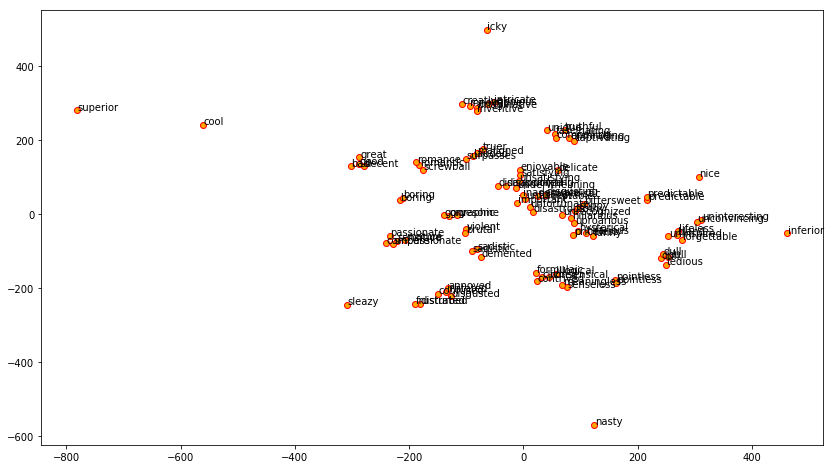

In [10]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')